In [36]:
import torch
import torchvision

In [37]:
#defining hyperparameters
n_epochs = 80
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
print("Cudnn status: ",torch.backends.cudnn.is_available())
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

Cudnn status:  True


In [38]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./mnist_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./mnist_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [39]:
#to check test_loader
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

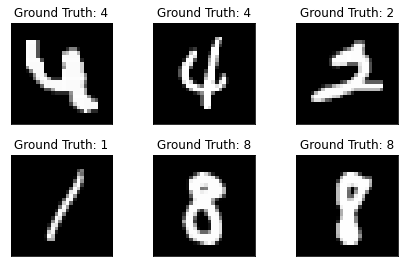

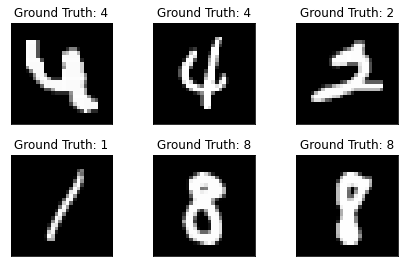

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Building the network

In [41]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [42]:
#create a class for the nerual network 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [43]:
network=Net()
network = network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [44]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(1,n_epochs + 1)]

In [45]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to('cuda')
    target = target.to('cuda')
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [46]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to('cuda')
      target = target.to('cuda')
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [47]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

76 [51840/60000 (86%)]	Loss: 0.120766
Train Epoch: 76 [52480/60000 (87%)]	Loss: 0.069460
Train Epoch: 76 [53120/60000 (88%)]	Loss: 0.059711
Train Epoch: 76 [53760/60000 (90%)]	Loss: 0.180906
Train Epoch: 76 [54400/60000 (91%)]	Loss: 0.144713
Train Epoch: 76 [55040/60000 (92%)]	Loss: 0.154845
Train Epoch: 76 [55680/60000 (93%)]	Loss: 0.157958
Train Epoch: 76 [56320/60000 (94%)]	Loss: 0.107638
Train Epoch: 76 [56960/60000 (95%)]	Loss: 0.041717
Train Epoch: 76 [57600/60000 (96%)]	Loss: 0.015950
Train Epoch: 76 [58240/60000 (97%)]	Loss: 0.046356
Train Epoch: 76 [58880/60000 (98%)]	Loss: 0.075358
Train Epoch: 76 [59520/60000 (99%)]	Loss: 0.029544

Test set: Avg. loss: 0.0259, Accuracy: 9912/10000 (99%)

Train Epoch: 77 [0/60000 (0%)]	Loss: 0.119417
Train Epoch: 77 [640/60000 (1%)]	Loss: 0.220048
Train Epoch: 77 [1280/60000 (2%)]	Loss: 0.108025
Train Epoch: 77 [1920/60000 (3%)]	Loss: 0.109677
Train Epoch: 77 [2560/60000 (4%)]	Loss: 0.127421
Train Epoch: 77 [3200/60000 (5%)]	Loss: 0.022623
Tr

In [48]:
print(test_losses)

[0.19607359161376953, 0.12526428909301757, 0.0973487548828125, 0.08275477638244629, 0.07539137573242187, 0.06620424194335937, 0.06379513969421387, 0.0574389232635498, 0.05120403785705566, 0.0506790168762207, 0.04746781501770019, 0.04646473045349121, 0.044634406280517576, 0.044914006805419925, 0.04142957534790039, 0.042003765869140626, 0.03895187931060791, 0.03798978614807129, 0.0378591947555542, 0.038404607009887695, 0.037196836471557616, 0.03677329387664795, 0.0348795539855957, 0.03538813247680664, 0.033583494758605954, 0.03324554786682129, 0.034421028327941895, 0.035350590705871585, 0.03503063488006592, 0.03683936862945557, 0.03428184413909912, 0.03402856979370117, 0.032336219692230224, 0.03205736351013184, 0.033660628128051755, 0.03195638103485107, 0.03208046398162842, 0.03107637767791748, 0.03024439926147461, 0.030353395652770995, 0.030501158332824706, 0.030459533882141114, 0.0312516788482666, 0.031650288486480715, 0.0297888240814209, 0.029113483333587646, 0.028404520988464355, 0.0

Text(0, 0.5, 'negative log likelihood loss')

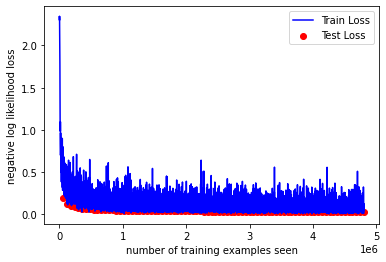

In [49]:
fig = plt.figure()

plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
